SfN  2022 Poster
Layout and plot everything

In [1]:
import sys
import os
sys.path.append('/data/GitHub/NeuroPy')
sys.path.append('/data/GitHub/TraceFC/')
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
%load_ext autoreload
%autoreload 2

import neuropy.io.miniscopeio as msio

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.neuroscopeio import NeuroscopeIO
from neuropy.io.binarysignalio import BinarysignalIO 
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.io.minianio import MinianIO
from neuropy.core.ca_neurons import CaNeurons, CaNeuronReg, PairwiseMap, MultiSessionMap
from neuropy.plotting.ca_events import RasterGroup, Raster
from neuropy.plotting.figure import Fig, Colormap
import session_directory as sd
from traceio import load_trace_events
from imaging.rasters import plot_paired_CS_PETH, plot_pe_traces

In [2]:
def create_fig_copy(panel_name, figdict=None):
    """Creates a copy of the figure with the correct layout but without other plots
    to avoid weird effects from constrained_layout=True"""
    PosterFign = Fig(size=(5.5*12,3.6*12), grid=(4, 4), width_ratios=[1, 2, 2, 2],
                height_ratios =[1, 2, 2, 2], fontsize=20)
    
    # Title placeholder
    ax_title = PosterFign.subplot(PosterFign.gs[0,:])
    ax_title.text(0.5, 0.3, 'TITLE HERE', fontdict={'fontsize': 50})
    
    # BACKGROUND BOX PLACEHOLDER
    ax_background = PosterFign.subplot(PosterFign.gs[1, 0])
    ax_background.set_title('BACKGROUND', fontdict={'fontsize': 40})
    
    # EXP OUTLINE PLACEHOLDER
    ax_outline = PosterFign.subplot(PosterFign.gs[2:, 0])
    ax_outline.set_title('EXP. OUTLINE', fontdict={'fontsize': 40})
    
    # METHODOLOGY PLACEHOLDER
    ax_meth = PosterFign.subplot(PosterFign.gs[1, 1])
    ax_meth.set_title('METHODOLOGY', fontdict={'fontsize': 40})
    
    if figdict is None:
        return {panel_name: PosterFign}
    else:
        figdict[panel_name] = PosterFign
        return figdict
        

In [3]:
%%capture
%matplotlib ipympl
PosterFig = Fig(size=(5.5*12,3.6*12), grid=(4, 4), width_ratios=[1, 2, 2, 2],
                height_ratios =[1, 2, 2, 2], fontsize=20)

In [4]:
# ax_title = PosterFig.subplot(PosterFig.gs[0,:])

# ax_title.text(0.5, 0.3, 'TITLE HERE', fontdict={'fontsize': 50})

### TEXT BOX PLACE HOLDERS

In [5]:
# # BACKGROUND BOX PLACEHOLDER
# ax_background = PosterFig.subplot(PosterFig.gs[1, 0])
# ax_background.set_title('BACKGROUND', fontdict={'fontsize': 40})

In [6]:
# # EXP OUTLINE PLACEHOLDER
# ax_outline = PosterFig.subplot(PosterFig.gs[2:, 0])
# ax_outline.set_title('EXP. OUTLINE', fontdict={'fontsize': 40})

In [7]:
# # METHODOLOGY PLACEHOLDER
# ax_meth = PosterFig.subplot(PosterFig.gs[1, 1])
# ax_meth.set_title('METHODOLOGY', fontdict={'fontsize': 40})

### Combined cell plots Example Rat (Finn)

In [8]:
import itertools
def make_careg(animal):
    # Specify sessions to plot here
    # Note animal cannot be Rat698, doesn't work for her
    sessions = ['Habituation2', 'Training', 'Recall1', 'Recall1']
    sesh_types = ['tone_habituation', 'training', 'tone_recall', 'control_tone_recall']
    CS_types = ['CS+', 'CS+', 'CS+', 'CS-']
    keep = [['good', 'maybe_interneurons']]*len(sessions)
    trim = [None]*len(sessions)

    if animal == 'Finn':
        for idt in np.where([sesh == 'Training' for sesh in sessions])[0]:
            keep[idt] = None
            trim[idt] = 'bad_units'  

    # Assemble data
    careg = CaNeuronReg([MinianIO(basedir=sd.get_session_dir(animal, session)).trim_neurons(keep=ke, trim=tr) 
                         for session, ke, tr in zip(sessions, keep, trim)], alias=sessions)
    
    # Define colors to match CS types above
    CS_colors = [[1, 0.647, 0, 0.3] if cs_type == 'CS+' else [0, 1, 0, 0.3] for cs_type in CS_types]

    return careg, sessions, sesh_types, CS_types, CS_colors

In [9]:
def make_rastgroup_and_map(animal, careg, sessions, sesh_types, CS_types, activity_type='C'):

    start_buffer, end_buffer = 10.0, 40.0
    rastgroups = []
    for sesh_name, sesh_type, CS_type in zip(sessions, sesh_types, CS_types):

        try:
            event_starts, event_ends = load_trace_events(sd.get_session_dir(animal, sesh_name), 
                                                         sesh_type, CS_type)
            rastgroups.append(RasterGroup(getattr(careg.get_session(sesh_name), activity_type), 
                                          careg.get_session(sesh_name).t['Timestamps'], 
                                          event_starts['Timestamp'], 
                                          event_ends['Timestamp'], 
                                          cell_ids=None, 
                                          start_buffer_sec=start_buffer, 
                                          end_buffer_sec=end_buffer))
        except ValueError: # Should catch any errors due to missing sessions for Rat698
            rastgroups.append(None)

    # Assemble maps
    map_sessions = ['Habituation2', 'Training','Recall1']
    msm = MultiSessionMap(pwmaps=[careg.load_pairwise_map(sesh1, sesh2) for sesh1, sesh2 in 
                           itertools.combinations(map_sessions, 2)], sesh_order=map_sessions)

    # Get full map for all sessions
    multi_sesh_map = msm.stepwise_reg(overwrite_indirect=True)
    
    # Load in event data
    events = [load_trace_events(sd.get_session_dir(animal, session), sesh_type, cs_type) 
              for session, sesh_type, cs_type in zip(sessions, sesh_types, CS_types)]
    
    return rastgroups, msm, multi_sesh_map, events

In [41]:
# Set up main example Rat: Finn
careg, sessions, sesh_types, CS_types, CS_colors = make_careg('Finn')
a, b, c, d = make_rastgroup_and_map('Finn', careg, sessions, sesh_types, CS_types, 
                                    activity_type='C')
rastgroups, msm, multi_sesh_map, events = a, b, c, d

Eliminating timestamps from corrupted video8 in 13_16_31 folder.
Keeping 38506 good frames found in "good_frames_bool.npy" file
Eliminating timestamps from corrupted video18 in 12_49_22 folder.
Keeping 125447 good frames found in "good_frames_bool.npy" file
Eliminating timestamps from corrupted video0 in 12_37_59 folder.
Eliminating timestamps from corrupted video6 in 12_40_13 folder.
Keeping 42497 good frames found in "good_frames_bool.npy" file
Eliminating timestamps from corrupted video0 in 12_37_59 folder.
Eliminating timestamps from corrupted video6 in 12_40_13 folder.
Keeping 42497 good frames found in "good_frames_bool.npy" file


### SINGLE CELL RESPONSES

In [42]:
# First get coactive neurons
coactive_bool = (multi_sesh_map > -1).sum(axis=1) >= 2
coactive_map = multi_sesh_map[coactive_bool]
ncoactive = coactive_map.shape[0]

map_use = coactive_map[sessions]
caneurons_use = [careg.get_session(sesh) for sesh in sessions]
map_use

,Habituation2,Training,Recall1,Recall1
1,1,-1,4,4
2,2,14,6,6
7,7,13,-1,-1
8,8,16,-1,-1
9,9,-1,9,9
10,10,17,11,11
12,12,21,16,16
13,13,-1,15,15
15,15,22,17,17
17,17,19,18,18


In [11]:
%%capture
# Example neurons from Finn
panel = create_fig_copy('single_cells')

# First get coactive neurons
coactive_bool = (multi_sesh_map > -1).sum(axis=1) >= 2
coactive_map = multi_sesh_map[coactive_bool]
ncoactive = coactive_map.shape[0]

map_use = coactive_map[sessions]
caneurons_use = [careg.get_session(sesh) for sesh in sessions]

good_neurons = [15, 24, 34]
_, ax = plot_paired_CS_PETH(caneurons_use, event_starts=[event[0] for event in events], 
                            event_ends=[event[1] for event in events], var_plot='C', 
                            neuron_inds=map_use.iloc[good_neurons,:].values.T, cs_types=CS_types, 
                            sesh_names=sesh_types, cs_color=CS_colors, plot_rast=True, cbar=False, 
                            cmap='viridis', rasterized=True, 
                            fig_or_gs_use=panel['single_cells'].gs[2, 1])


In [ ]:
_, ax19 = plt.subplots(2, 4, figsize=8.5, 4.5)
plot_paired_CS_PETH(caneurons_use, event_starts=[event[0] for event in events], 
                            event_ends=[event[1] for event in events], var_plot='C', 
                            neuron_inds=map_use.iloc[19,:].values.T, cs_types=CS_types, 
                            sesh_names=sesh_types, cs_color=CS_colors, plot_rast=True, cbar=False, 
                            cmap='viridis', rasterized=True, 
                            fig_or_gs_use=ax19)

In [12]:
%%capture
# Fig to hold extra potential Single cell responses!
PosterFig2 = Fig(num="Poster Fig alternative panels", size=(5.5*12,3.8*12), grid=(4, 4), 
                 width_ratios=[1, 2, 2, 2], height_ratios =[1, 2, 2, 2], fontsize=20)

In [13]:
# Grab example cells from other animals and plot to alternative poster figure
alt_animals = ['Rose', 'Rose', 'Jyn', 'Rey']
alt_cells = [[2, 5, 9], [6, 8, 14], [1, 6, 11], [14, 12, 13]]
gs_use = [PosterFig2.gs[1, 1], PosterFig2.gs[2, 1], PosterFig2.gs[1, 2], 
          PosterFig2.gs[2, 2]]
for alt_animal, good_neurons, alt_gs in zip(alt_animals, alt_cells, gs_use):
    careg_alt, sessions, sesh_types, CS_types, CS_colors = make_careg(alt_animal)
    outs = make_rastgroup_and_map(alt_animal, careg_alt, sessions, sesh_types, 
                                  CS_types, activity_type='C')
    rastgroups_alt, msm_alt, multi_sesh_map_alt, events_alt = outs
    # First get coactive neurons
    coactive_bool_alt = (multi_sesh_map_alt > -1).sum(axis=1) >= 2
    coactive_map_alt = multi_sesh_map_alt[coactive_bool_alt]
    ncoactive_alt = coactive_map_alt.shape[0]

    map_use_alt = coactive_map_alt[sessions]
    caneurons_use_alt = [careg_alt.get_session(sesh) for sesh in sessions]

    _, ax = plot_paired_CS_PETH(caneurons_use_alt, event_starts=[event[0] for event in events_alt], 
                                event_ends=[event[1] for event in events_alt], var_plot='C', 
                                neuron_inds=map_use_alt.iloc[good_neurons,:].values.T, cs_types=CS_types, 
                                sesh_names=sesh_types, cs_color=CS_colors, plot_rast=True, cbar=False, 
                                cmap='viridis', rasterized=True, fig_or_gs_use=alt_gs)


Keeping 38191 good frames found in motion.zarr file
Keeping 171437 good frames found in "frames.npy" file
Keeping 48590 good frames found in "frames.npy" file
Keeping 48590 good frames found in "frames.npy" file
Keeping 38191 good frames found in motion.zarr file
Keeping 171437 good frames found in "frames.npy" file
Keeping 48590 good frames found in "frames.npy" file
Keeping 48590 good frames found in "frames.npy" file
Keeping 38282 good frames found in "good_frames_bool.npy" file
Eliminating timestamps from corrupted video10 in 12_46_16 folder.
Keeping 152933 good frames found in "good_frames_bool.npy" file
Keeping 47329 good frames found in "good_frames_bool.npy" file
Keeping 47329 good frames found in "good_frames_bool.npy" file
Merge params not found in either PairwiseMap or CaNeuronReg. Double check merging ok before proceeding!
Merge params not found in either PairwiseMap or CaNeuronReg. Double check merging ok before proceeding!
Merge params not found in either PairwiseMap or C

### POPULATION CA IMAGING - Snake Plots

In [14]:
%%capture
panel = create_fig_copy("snake", panel)
ax_snake = panel["snake"].subplot2grid(panel["snake"].gs[3, 1], grid=(2, 4), return_axes=True)
sort_ids = []  # keep track of how you sorted things
for a, rgroup, sesh_name, CStype in zip(ax_snake[0], rastgroups, sessions, CS_types):
    if rgroup is not None:
        ids = rgroup.snake_plot(sortby="peak_time", ax=a, cbar=False, rasterized=True)
        sort_ids.append(ids)
        a.set_title(f"{sesh_name}: {CStype}", fontdict={'fontsize': 32})

In [43]:
map_use = msm.grab_map(['Habituation2', 'Recall1'], coactive_only=True)
cells_to_grab = map_use['Habituation2'].values  # Get cells active in this session

In [46]:
map_use = msm.grab_map(['Habituation2', 'Training'], coactive_only=False).loc[cells_to_grab]
map_use

,Habituation2,Training
1,1,-1
2,2,14
9,9,-1
10,10,17
12,12,21
13,13,-1
15,15,22
17,17,19
18,18,27
19,19,29


In [37]:
sort_id

array([14,  8,  5,  0,  1, 11,  9, 10,  2, 12,  6,  7, 13,  4,  3])

In [ ]:
_, ax = plt.subplots()

In [15]:
ax_reg = ax_snake[1]
map_use = msm.grab_map(['Habituation2', 'Recall1'], coactive_only=True)
cells_to_grab = map_use['Habituation2'].values  # Get cells active in this session

# Plot Habituation2 first with blue box around it
sort_id = rastgroups[0].cell_slice(map_use['Habituation2'].values).snake_plot(sortby="peak_time", ax=ax_reg[0], 
                                                                              cbar=False, rasterized=True)
ax_reg[0].set_title('Habituation2: CS+', fontdict={'fontsize': 32})
plt.setp(ax_reg[0].spines.values(), color='b', linewidth=8)
sns.despine(left=False, right=False, top=False, bottom=False, ax=ax_reg[0])

# Plot Recall1 CS+
rastgroups[2].cell_slice(map_use['Recall1'].values).snake_plot(sortby=sort_id, ax=ax_reg[2], 
                                                               cbar=False, rasterized=True)
ax_reg[2].set_title('Recall1: CS+', fontdict={'fontsize': 32})

# Plot Recall1 CS-
rastgroups[3].cell_slice(map_use['Recall1'].values).snake_plot(sortby=sort_id, ax=ax_reg[3], 
                                                               cbar=False, rasterized=True)
ax_reg[3].set_title('Recall1: CS-', fontdict={'fontsize': 32})

# Last fill in Training
map_use = msm.grab_map(['Habituation2', 'Training'], coactive_only=False).loc[cells_to_grab]
rastgroups[1].cell_slice(map_use['Training'].values).snake_plot(sortby=sort_id, ax=ax_reg[1], 
                                                               cbar=False, rasterized=True)
ax_reg[1].set_title('Training: CS+', fontdict={'fontsize': 32})



/data/GitHub/NeuroPy/neuropy/plotting/ca_events.py:47: RuntimeWarning: Mean of empty slice
  np.nanmean(self.raster, axis=0) if self.raster is not None else None
/data/GitHub/NeuroPy/neuropy/plotting/ca_events.py:563: RuntimeWarning: invalid value encountered in true_divide
  sorted_mean_rast = sorted_mean_rast / sorted_mean_rast.max(axis=1)[:, None]


Text(0.5, 1.0, 'Training: CS+')

### Combined cell plots all animals

In [16]:
# ax_snake_all = PosterFig.subplot(PosterFig.gs[3, 2])

### SWR - PL coupling

In [17]:
# ax_SWR = PosterFig.subplot(PosterFig.gs[1, 2])
# ax_SWR.set_title('SWR-PL COUPLING', fontdict={'fontsize': 40})

In [18]:
# Define a class for a typical recording or set of recordings
class ProcessData:
    def __init__(self, basepath):
        basepath = Path(basepath)
        self.basepath = basepath
        xml_files = sorted(basepath.glob("*.xml"))
        assert len(xml_files) == 1, "Found more than one .xml file"
        
        fp = xml_files[0].with_suffix("")
        self.filePrefix = fp
        
        self.recinfo = NeuroscopeIO(xml_files[0])
        self.eegfile = BinarysignalIO(basepath / 'Finn_training_denoised.eeg',
                                     n_channels=self.recinfo.n_channels,
                                     sampling_rate=self.recinfo.eeg_sampling_rate,
                                     )
        try:
            self.datfile = BinarysignalIO(basepath / 'Finn_training_denoised.dat',
                                         n_channels=self.recinfo.n_channels,
                                         sampling_rate=self.recinfo.dat_sampling_rate,
                                         )
        except FileNotFoundError:
            print('No dat file found, not loading')
                
        
    def __repr__(self) -> str:
        return f"{self.__class__.__name__}({self.recinfo.source_file.name})"
    
def Finn_training():
    basepath = '/data2/Trace_FC/Recording_Rats/Finn/2022_01_20_training' # for linux desktop
    return ProcessData(basepath)


In [19]:
sess = Finn_training()
minian = MinianIO(basedir=sess.basepath)
sess.caneurons = minian.trim_neurons(keep=None, trim="bad_units")
print(sess.recinfo)
print(sess.eegfile)

Eliminating timestamps from corrupted video18 in 12_49_22 folder.
Keeping 125447 good frames found in "good_frames_bool.npy" file
filename: /data2/Trace_FC/Recording_Rats/Finn/2022_01_20_training/Finn_training_denoised.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250

duration: 17303.33 seconds 
duration: 4.81 hours 



In [20]:
from neuropy.core.epoch import Epoch
sess.ripple= Epoch(epochs=None, file=sess.filePrefix.with_suffix('.ripple_curated.npy'))
sess.ripple.epochs = sess.ripple.to_dataframe()
print(f'{sess.ripple.epochs["good_ripple"].sum()} hand-curated ripples detected')

574 hand-curated ripples detected


In [21]:
# Load in timestamps to all ripples
from neuropy.io.openephysio import get_dat_timestamps, get_lfp_timestamps
timestamps = get_lfp_timestamps(sess.basepath)

# Check # frames in timestamps matches that of eeg file
if sess.eegfile.n_frames == timestamps.shape[0]:
    print('# frames in timestamps file and eegfile match. Good to go!')
# Import eeg_times

eeg_times = pd.DataFrame({'frame': np.arange(sess.eegfile.n_frames), 
                          'time (s)': np.arange(sess.eegfile.n_frames)/sess.eegfile.sampling_rate, 
                          'Timestamps': timestamps.loc[:, 0].dt.tz_localize(None)})

# Now insert timestamps for all ripples!
start_frames = np.interp(sess.ripple.epochs['start'], eeg_times['time (s)'], 
                         eeg_times['frame']).astype(int)
stop_frames = np.interp(sess.ripple.epochs['stop'], eeg_times['time (s)'], 
                        eeg_times['frame']).astype(int)

sess.ripple.epochs.insert(5, 'Start Timestamp', 
                          eeg_times['Timestamps'].iloc[start_frames].values)
sess.ripple.epochs.insert(6, 'Stop Timestamp', 
                          eeg_times['Timestamps'].iloc[stop_frames].values)

start time = 2022-01-20 12:28:41.457273-05:00
start time = 2022-01-20 12:41:05.080921-05:00
start time = 2022-01-20 12:49:07.058155-05:00
start time = 2022-01-20 13:11:28.552226-05:00
start time = 2022-01-20 13:23:42.352374-05:00
start time = 2022-01-20 15:04:44.374794-05:00
start time = 2022-01-20 15:52:30.413963-05:00
start time = 2022-01-20 15:52:30.413963-05:00
# frames in timestamps file and eegfile match. Good to go!


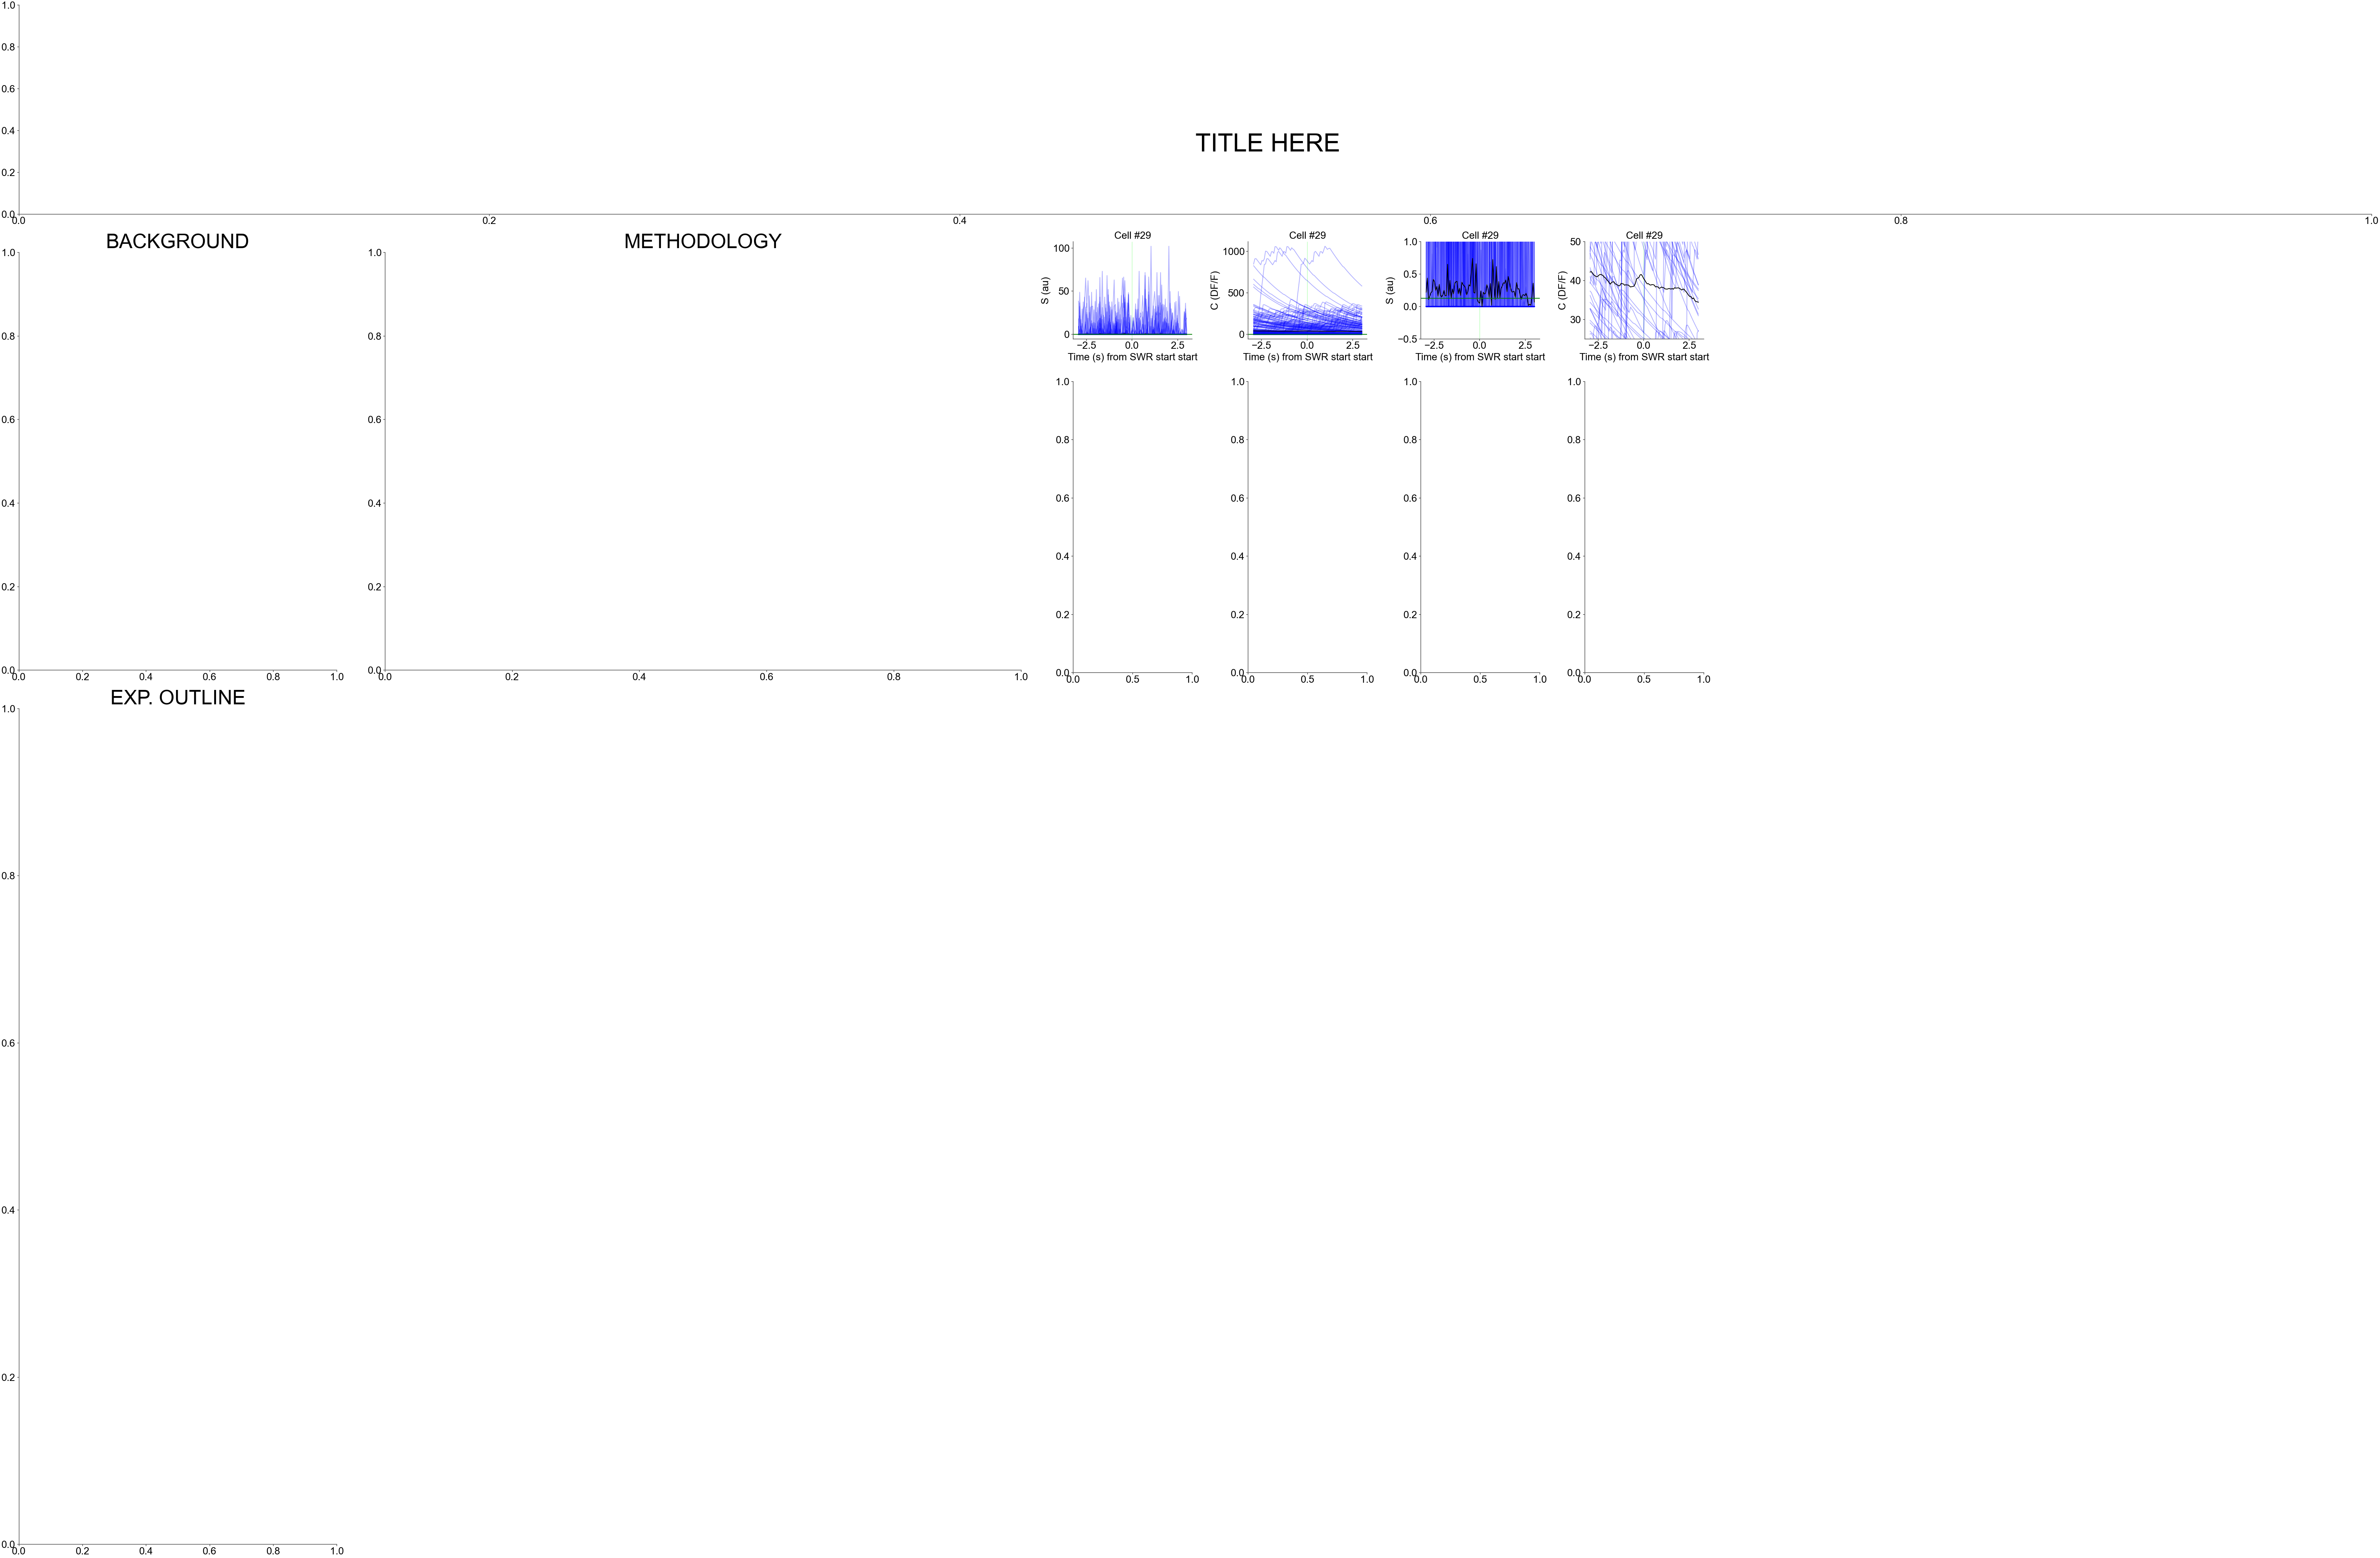

In [22]:
%%capture
panel = create_fig_copy("SWRPL", panel)
axSWRPL = panel["SWRPL"].subplot2grid(panel["SWRPL"].gs[1, 2], grid=(2, 4), height_ratios=[1, 3],
                                 return_axes=True)
cell_plot = 29
cell_lims = [[-0.5, 1], [25, 50]]
for a in [axSWRPL[0][0:2], axSWRPL[0][2:]]:
    plot_pe_traces(sess.caneurons.t['Timestamps'], sess.caneurons.S,
                   sess.ripple.epochs['Start Timestamp'][sess.ripple.epochs['good_ripple']], 
                   raw_trace=sess.caneurons.C, start_buffer_sec=3, 
                   end_buffer_sec=3, event_type='SWR start', 
                   ylabels=['S (au)', 'C (DF/F)'], ax=a, cell_id=cell_plot)

for lims, a in zip(cell_lims, axSWRPL[0][2:]):
    a.set_ylim(lims)

In [23]:
# cell_ids = [32, 33,  7, 48,  4, 35, 46, 52, 29]
# fig_list, raw_rast_array = [], []
# nneurons = sess.caneurons.S[cell_ids].shape[0]
# fig, ax = plt.subplots(nneurons, 2, figsize=(6.5, 3*nneurons))

# for activity, raw_activity, a, cell_id in zip(sess.caneurons.S[cell_ids], 
#                                   sess.caneurons.C[cell_ids],
#                                   ax, cell_ids):
#     fig, _, _, _, _ = plot_pe_traces(sess.caneurons.t['Timestamps'], activity,
#                                      sess.ripple.epochs['Start Timestamp'][sess.ripple.epochs['good_ripple']], 
#                                      raw_trace=raw_activity, start_buffer_sec=3, 
#                                      end_buffer_sec=3, event_type='SWR start', 
#                                      ylabels=['S (au)', 'C (DF/F)'], ax=a,
#                                      cell_id=cell_id)
#     fig_list.append(fig)
    
# ax_ylims47 = [[-0.1, 0.5], [-1.0, 6.0]]
# ax_ylims32 = [[-0.5, 2.0], [40.0, 63.0]]
# ax_ylims29 = [[-0.5, 1], [25, 50]]

In [24]:
# Attempt to make a raster group and plot out a snake plot of all the neurons
sess.swr_rasts = RasterGroup(sess.caneurons.C, sess.caneurons.t['Timestamps'], 
                             sess.ripple.epochs['Start Timestamp'][sess.ripple.epochs['good_ripple']], 
                             None, cell_ids=None, start_buffer_sec=3, 
                             end_buffer_sec=3)

In [25]:
# Divide up events into two groups to check consistency
sess.swr_rasts1 = RasterGroup(sess.caneurons.C, sess.caneurons.t['Timestamps'], 
                             sess.ripple.epochs['Start Timestamp'][sess.ripple.epochs['good_ripple']][0::2], 
                             None, cell_ids=None, start_buffer_sec=3, 
                             end_buffer_sec=3)
sess.swr_rasts2 = RasterGroup(sess.caneurons.C, sess.caneurons.t['Timestamps'], 
                             sess.ripple.epochs['Start Timestamp'][sess.ripple.epochs['good_ripple']][1::2], 
                             None, cell_ids=None, start_buffer_sec=3, 
                             end_buffer_sec=3)

In [26]:
# fig, ax = plt.subplots(1, 3, figsize=(8.5, 3.5))

mid_time = [-0.5, 0.5]
rast_time = sess.swr_rasts.Raster[0].raster_time
mid_bool = np.bitwise_and(rast_time < mid_time[1], rast_time > mid_time[0])
zmid_sum = []
for rast in sess.swr_rasts.Raster:
    rast_use = rast.raster
    rast_mean = rast.raster_mean
    
    zmid_sum.append(((rast_mean[mid_bool] - np.nanmean(rast_use.reshape(-1)))/
                    np.nanstd(rast_use.reshape(-1))).sum())

idzsort = np.argsort(zmid_sum)
for a, title_use, swr_rasts_use in zip(axSWRPL[1][0:3], ['All', 'Even SWRs', 'Odd SWRs'], 
                                   [sess.swr_rasts, sess.swr_rasts1, sess.swr_rasts2]):
    swr_rasts_use.snake_plot(sortby=idzsort, xlabel_increment=1, norm_each_row="z", 
                             ax=a, rasterized=True, cbar=False)
    a.set_title(title_use)

In [27]:
# Get consistency of SWR modulation for above plots
s1, _ = sess.swr_rasts1.sort_rasters(sortby=idzsort, norm_each_row='z')
s2, _ = sess.swr_rasts2.sort_rasters(sortby=idzsort, norm_each_row='z')

corrs = []
for cell1, cell2 in zip(s1, s2):
    corrs.append(np.corrcoef(cell1, cell2)[0][1])
corrs = np.array(corrs)

corrs_shuf = []
nshuf = 1000
for n in range(nshuf):
    np.random.shuffle(s2)
    corrs_temp = []
    for cell1, cell2 in zip(s1, s2):
        corrs_temp.append(np.corrcoef(cell1, cell2)[0][1])
    corrs_shuf.append(corrs_temp)
corrs_shuf = np.array(corrs_shuf)  

pconsist = (corrs[None, :] < corrs_shuf).sum(axis=0)/nshuf
print(pconsist)

# Label significantly consistent rows
ax_use = axSWRPL[1][0:3]
pthresh = 0.1
trans = ax_use[1].get_yaxis_transform()
nbins = swr_rasts_use.Raster[0].raster.shape[1]
for py in np.where(pconsist < pthresh):
    for a in ax_use:
        a.plot([nbins*1.02]*2, [py + 0.2, py+0.8], color='k', linewidth=6, clip_on=False)

[0.085 0.314 0.669 0.065 0.48  0.903 0.944 0.076 0.13  0.    0.401 0.4
 0.266 0.266 0.272 0.125 0.184 0.16  0.151 0.599 0.586 0.977 0.15  0.308
 0.607 0.364 0.024 0.708 0.399 0.411 0.907 0.361 0.099 0.978 0.415 0.361
 0.14  0.564 0.442 0.915 0.446 0.178 0.048 0.954 0.3   0.277 0.331 0.02
 0.013 0.331 0.242 0.533 0.752]


In [28]:
print(idzsort[pconsist < pthresh])
print(pconsist[pconsist < pthresh])

[32 33  7 48  4 35 46 52 29]
[0.085 0.065 0.076 0.    0.024 0.099 0.048 0.02  0.013]


## TODOS
1) Plot behavior in same way as CS rasters - show for habituation2 session.   
2) Plot spectrogram for each CS in same manner! Overlay...  
3) Plot event rate for all neurons in each arena on recall day - does it differ?  
4) If possible plot ephys activity rasters during CS presentations for cells from Han maybe?

## Save Figure!

In [29]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')


<IPython.core.display.Javascript object>

In [30]:
 # Get notebook name
nb_full_path = os.path.join(os.getcwd(), nb_name)

In [32]:
savedir = Path('/home/nkinsky/Dropbox/UM/SfN/2022/Poster/')
for panel_name, panel_fig in panel.items():
    panel_fig.savefig(savedir / panel_name, scriptname=nb_full_path)

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


In [ ]:
# PosterFig.savefig(Path('/home/nkinsky/Dropbox/UM/SfN/2022/Poster/SfN_Poster2022.pdf'), 
#                  scriptname=nb_full_path)

In [31]:
# Run and save this separately - lots of memory issues if you don't -> corrupt file when saved
# PosterFig2.savefig(Path('/home/nkinsky/Dropbox/UM/SfN/2022/Poster/SfN_Alt_Poster2022.pdf'), 
#                  scriptname=nb_full_path)

meta NOT subset; don't know how to subset; dropped
